In [1]:
from tinygrad import Tensor, nn
import fastcore.all as fc
import torch, torchvision
from miniai.datasets import *


In [2]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [3]:

def conv_block(in_channels, out_channels):
    # your code here
    return nn.Conv2d(in_channels, out_channels, 3, padding=(1,1))

In [4]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(torch.tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


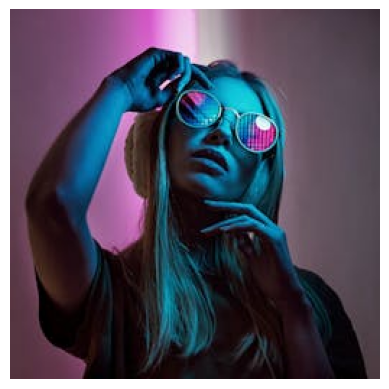

In [5]:
content_im = download_image(face_url).to("mps")
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [6]:
content_im.data.device

device(type='mps', index=0)

In [7]:
from tinygrad.dtype import _from_torch_dtype
from tinygrad import Device

In [8]:
class Hook:
    pass

In [9]:
class Relu:
    def __call__(self, inp):
        return inp.relu()

In [10]:
class MaxPool2d:
    def __init__(self, kernel_size, stride):
        fc.store_attr()
    def __call__(self, inp):
        outp = inp.max_pool2d(self.kernel_size, self.stride)
        return outp

In [11]:
class VGG16():
    def __init__(self):
        self.conv1_1 = conv_block(3,64)             #0
        self.relu1 = Relu()                         #1
        self.conv1_2 = conv_block(64,64)            #2
        self.relu2 = Relu()                         #3
        self.max_pool1 = MaxPool2d((2,2), 2)        #4

        self.conv2_1 = conv_block(64, 128)          #5
        self.relu3 = Relu()                         #6
        self.conv2_2 = conv_block(128, 128)         #7
        self.relu4 = Relu()                         #8
        self.max_pool2 = MaxPool2d((2,2), 2)        #9
        
        self.conv3_1 = conv_block(128, 256)         #10
        self.relu5 = Relu()                         #11
        self.conv3_2 = conv_block(256, 256)         #12
        self.relu6 = Relu()                         #13
        self.conv3_3 = conv_block(256, 256)         #14
        self.relu7 = Relu()                         #15
        self.max_pool3 = MaxPool2d((2,2), 2)        #16

        self.conv4_1 = conv_block(256, 512)         #17
        self.relu8 = Relu()                         #18
        self.conv4_2 = conv_block(512, 512)         #19
        self.relu9 = Relu()                         #20
        self.conv4_3 = conv_block(512, 512)         #21
        self.relu10 = Relu()                        #22
        self.max_pool4 = MaxPool2d((2,2), 2)        #23
        
        self.conv5_1 = conv_block(512, 512)         #24
        self.relu11 = Relu()
        self.conv5_2 = conv_block(512, 512)         #25
        self.relu12 = Relu()                        #26
        self.conv5_3 = conv_block(512, 512)         #27
        self.relu13 = Relu()                        #28
        self.max_pool5 = MaxPool2d((2,2), 2)        #29
        
        self.fc1 = nn.Linear(512*7*7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)


        self.features = [
            self.conv1_1,
            self.relu1,
            self.conv1_2,
            self.relu2,
            self.max_pool1,
            
            self.conv2_1, 
            self.relu3,
            self.conv2_2,
            self.relu4,
            self.max_pool2,
            
            self.conv3_1,
            self.relu5,
            self.conv3_2,
            self.relu6,
            self.conv3_3,
            self.relu7,
            self.max_pool3,

            self.conv4_1,
            self.relu8,
            self.conv4_2,
            self.relu9,
            self.conv4_3,
            self.relu10,
            self.max_pool4,
            
            self.conv5_1,
            self.relu11,
            self.conv5_2,
            self.relu12,
            self.conv5_3,
            self.relu13,
            self.max_pool5,
        ]
        self.fully_connected = [            
            self.fc1,
            self.fc2,
            self.fc3
        ]

        self.layers = [
            *self.features,
            *self.fully_connected
        ]
    def __getitem__(self, i):
        return self.layers[i]

    def __call__(self, inp, features_only=False):
        selected_layers = self.features if features_only else self.layers
        x = inp
        for layer in selected_layers:
            x = layer(x)
            if hasattr(layer,'hooks'):
                for h in layer.hooks:
                    h.outp = x
        return x

In [12]:
import torch
import torchvision.models as models


In [13]:
vgg16_trained = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

In [14]:
# !ls ~/.cache/torch/hub/checkpoints/vgg16-397923af.pth

In [15]:
state_dict = vgg16_trained.state_dict()


In [16]:
state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [17]:
# this doesn't work on metal pytorch
# from tinygrad.dtype import _from_torch_dtype

# def torch_to_tiny(dict_key):
#     tt = Tensor.from_blob(state_dict[dict_key].data_ptr(), state_dict[dict_key].shape, dtype=_from_torch_dtype(state_dict[dict_key].dtype), device=Device.DEFAULT)
#     torch.mps.synchronize()
#     return tt

In [18]:
def torch_to_tiny(torch_tensor):
    tt = Tensor(torch_tensor.detach().cpu().numpy().copy())
    return tt

In [19]:
def get_vgg_weight(dict_key):
    w = torch_to_tiny(state_dict[dict_key])
    return w

In [20]:
def load_vgg16():
    model = VGG16()
    weight_map = [
        ('conv1_1', 'features.0'),
        ('conv1_2', 'features.2'),
        
        ('conv2_1','features.5'),
        ('conv2_2','features.7'),
        
        ('conv3_1', 'features.10'),
        ('conv3_2', 'features.12'),
        ('conv3_3', 'features.14'),
    
        ('conv4_1', 'features.17'),
        ('conv4_2', 'features.19'),
        ('conv4_3', 'features.21'),
    
        ('conv5_1', 'features.24'),
        ('conv5_2', 'features.26'),
        ('conv5_3', 'features.28'),
    
        ('fc1', 'classifier.0'),
        ('fc2', 'classifier.3'),
        ('fc3', 'classifier.6'),
    ]

    for layer,key in weight_map:
        getattr(model, f"{layer}").weight = get_vgg_weight(f"{key}.weight")
        getattr(model, f"{layer}").bias = get_vgg_weight(f"{key}.bias")
    return model

In [21]:
def normalize(im):
    imagenet_mean = Tensor([0.485, 0.456, 0.406])[:,None,None]
    imagenet_std = Tensor([0.229, 0.224, 0.225])[:,None,None]
    return (im - imagenet_mean) / imagenet_std

In [22]:
content_im = torch_to_tiny(content_im)

In [23]:
normalized = normalize(content_im)

In [24]:
model = load_vgg16()

In [25]:
def calc_features(imgs, layers=(18,25)):
    imgs = imgs.unsqueeze(0)
    x = normalize(imgs)
    
    for l in layers:
        h = Hook()
        model[l].hooks = []
        model[l].hooks.append(h)

    model(x, features_only=True)
    feats = []
    for l in layers:
        # .squeeze to account to reverse the unsqueeze before passing the image to to the model
        feats.append(model[l].hooks[0].outp.squeeze())
        model[l].hooks = []

    return feats

In [27]:
features = calc_features(content_im)

In [28]:
normalize(content_im).min().numpy(), normalize(content_im).max().numpy()

(array(-2.117904, dtype=float32), array(2.64, dtype=float32))

In [29]:
[(f.min().numpy(), f.max().numpy()) for f in features]

[(array(0., dtype=float32), array(110.273735, dtype=float32)),
 (array(0., dtype=float32), array(33.943405, dtype=float32))]

In [30]:
[f.shape for f in features]

[(512, 32, 32), (512, 16, 16)]

In [31]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18,25)):
        fc.store_attr()
        Tensor.training = False
        self.target_features = calc_features(target_im, target_layers)
        Tensor.training = True

    def __call__(self, input_im):
        k = zip(calc_features(input_im, self.target_layers), self.target_features)
        values = []
        for f1,f2 in k:
            v = (f1-f2).pow(2).mean()
            values.append(v)
        return sum(values)
               

In [32]:
content_im.device

'METAL'

In [33]:
def show_tiny_image(img_tensor):
    return show_image(torch.from_numpy(img_tensor if type(img_tensor).__name__ == 'ndarray' else img_tensor.numpy()))

In [34]:
def show_tiny_images(images):
    for image in images:
        show_tiny_image(image.clip(0, 1))

In [35]:
from tqdm.notebook import tqdm

<Axes: >

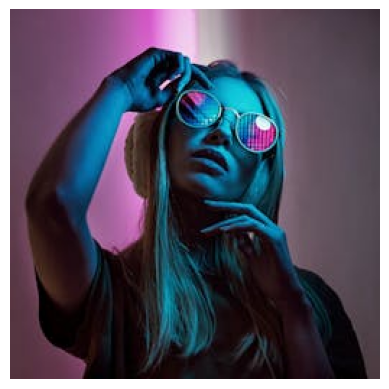

In [36]:
show_tiny_image(content_im)

In [37]:
# images = []

# # Set up the optimizer
# im = Tensor.rand(3, 256, 256)
# opt = nn.optim.Adam([im], lr=1e-2)

# # Define the loss function
# content_loss = ContentLossToTarget(content_im, target_layers=(1,6)) 
# # Optimization loop

# with Tensor.train():
#     for i in tqdm(range(200)):
#         loss = content_loss(im)
#         loss.backward()
#         if i%20 == 0 :
#             print(f"epoch: {i}, loss: {loss.item()} grad: {im.grad.numpy().sum()}")
#             images.append(im.numpy())
            
#         opt.step()
#         opt.zero_grad()
# # Show the result
# show_tiny_image(im.clip(0, 1));

In [38]:
# show_tiny_images(images)

In [39]:
from fastcore.foundation import L

In [40]:
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    
    return L(Tensor.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

In [41]:
style_im = download_image(spiderweb_url).to("mps")

In [42]:
style_im

tensor([[[0.2196, 0.1725, 0.0784,  ..., 0.0824, 0.1137, 0.1373],
         [0.0941, 0.0392, 0.0353,  ..., 0.0706, 0.0902, 0.1020],
         [0.0118, 0.0196, 0.0941,  ..., 0.0549, 0.0588, 0.0627],
         ...,
         [0.5529, 0.5373, 0.4510,  ..., 0.3765, 0.3922, 0.6000],
         [0.4863, 0.5451, 0.5608,  ..., 0.3765, 0.3922, 0.6000],
         [0.1529, 0.3137, 0.4863,  ..., 0.3765, 0.3922, 0.6000]],

        [[0.2196, 0.1725, 0.0784,  ..., 0.0824, 0.1137, 0.1373],
         [0.0941, 0.0392, 0.0353,  ..., 0.0706, 0.0902, 0.1020],
         [0.0118, 0.0196, 0.0941,  ..., 0.0549, 0.0588, 0.0627],
         ...,
         [0.5529, 0.5373, 0.4510,  ..., 0.3765, 0.3922, 0.6000],
         [0.4863, 0.5451, 0.5608,  ..., 0.3765, 0.3922, 0.6000],
         [0.1529, 0.3137, 0.4863,  ..., 0.3765, 0.3922, 0.6000]],

        [[0.2196, 0.1725, 0.0784,  ..., 0.0824, 0.1137, 0.1373],
         [0.0941, 0.0392, 0.0353,  ..., 0.0706, 0.0902, 0.1020],
         [0.0118, 0.0196, 0.0941,  ..., 0.0549, 0.0588, 0.

content_im.shape: (3, 171, 256)


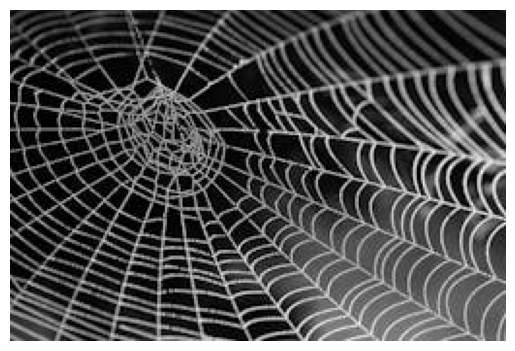

In [43]:
style_im = torch_to_tiny(style_im)
print('content_im.shape:', style_im.shape)
show_tiny_image(style_im);

In [44]:
style_im.shape

(3, 171, 256)

In [45]:
style_grams = calc_grams(style_im)

In [46]:
len(style_grams)

5

In [47]:
style_grams.attrgot('shape')

(#5) [(64, 64),(128, 128),(256, 256),(512, 512),(512, 512)]

In [48]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

  0%|          | 0/300 [00:00<?, ?it/s]

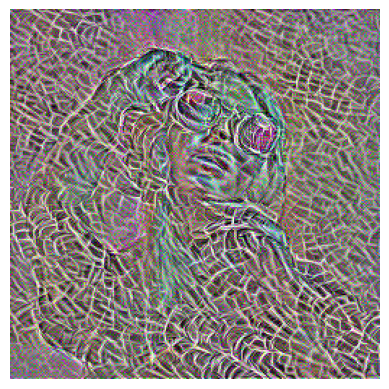

In [49]:
images = []

# Set up the optimizer
im = Tensor.rand(3, 256, 256)
opt = nn.optim.Adam([im], lr=1e-2)

# Define the loss function
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])

def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
# Optimization loop

with Tensor.train():
    for i in tqdm(range(300)):
        loss = combined_loss(im)
        loss.backward()
        # if i%20 == 0 :
        #     print(f"epoch: {i}, loss: {loss.item()} grad: {im.grad.numpy().sum()}")
        #     images.append(im.numpy())
            
        opt.step()
        opt.zero_grad()
# Show the result
show_tiny_image(im.clip(0, 1));

In [52]:
im.shape

(3, 256, 256)